This notebook demonstrates using SNMR data to produce transmissivity maps for each aquifer in the East Kimberley Keep s74 area.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * df['Total_water_content'].values * df['T2*'].values

def point_within_bounds(x,y, bounds):
    if (bounds.left < x) & (bounds.right > x):
        if (bounds.bottom < y) & (bounds.top > y):
            return True
    return False

In [4]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database


SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']


DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              s.geometry,
              s.elevation,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID";"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]


In [5]:
df_acquisitions

,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation
acquisition_id,,,,,,,,,
0,0,MillProf,466505.9100,8316696.170,"POLYGON ((466296.2798914838 8316647.306548808,...",51.9092788696289,FID,40.0,45.148358
2,1,saltflats_st1,468448.6660,8354121.638,"POLYGON ((468500.9411914838 8354169.254548808,...",3.14211177825928,FID,40.0,24.773026
3,2,2pm,468863.3010,8347878.272,"POLYGON ((468914.1478914838 8347926.009548808,...",44.4337348937988,FID,40.0,79.434384
5,3,7m,464216.0790,8350319.661,"POLYGON ((464250.9278914838 8350216.810548807,...",18.368709564209,FID,40.0,79.434384
7,4,6m,458571.4590,8345568.043,"POLYGON ((458622.3728914838 8345611.113548808,...",62.8852462768555,FID,40.0,74.430066
9,5,strat_trans_st3,458155.4900,8345306.897,"POLYGON ((458171.9589914838 8345485.717548807,...",56.8076019287109,FID,40.0,79.434384
10,6,strat_trans_st2,457781.0190,8345010.551,"POLYGON ((457794.8020914838 8345219.131548807,...",57.7543334960938,FID,40.0,74.430066
12,7,4m,476976.7710,8318919.739,"POLYGON ((477026.6028914838 8318967.239548807,...",106.796394348145,FID,40.0,65.060885
13,8,centr_spat_st_2,475577.6060,8325315.362,"POLYGON ((475629.5678914838 8325364.449548807,...",87.2679290771484,FID,40.0,84.658130


In [37]:
# Lets bring in the major surfaces in mAHD so we can start assigning observations to each SNMR observation

water_table = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\raster_elevation_interpolation\nulled\KeepRiver_waterTable_mAHD.tif"
base_ceno = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\Neil\elevatoin\Cz_base.tif"
top_mill = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\AEM_interp_OrdKeep\Neil\elevatoin\Clm_top.tif"


In [38]:
# Now for each site we want to attribute the SNMR based on this


df_acquisitions['base_ceno'] = np.nan

df_acquisitions['top_mill'] = np.nan

df_acquisitions['water_table_mAHD'] = np.nan

# Add the layer_boundary depths to the dataframe

# Open the tif files
wt_src = rasterio.open(water_table)

ceno_src = rasterio.open(base_ceno)

mill_src = rasterio.open(top_mill)



wt_bounds = wt_src.bounds
ceno_bounds = ceno_src.bounds
mill_bounds = mill_src.bounds

In [41]:
# Iterate through the sites and add the raster value to the dataframe
# if it is within the extent of the raster
for index, row in df_acquisitions.iterrows():
    # get the coords
    x, y = row.mid_X, row.mid_Y
    # Water table
    if point_within_bounds(x,y, wt_bounds):
        
        wt = next(wt_src.sample(np.array([[x,y]])))[0]

        
        if wt > -900:
            df_acquisitions.at[index, 'water_table_mAHD'] = wt
    # Base ceno
    if point_within_bounds(x,y, ceno_bounds):
        
        baseceno = next(ceno_src.sample(np.array([[x,y]])))[0]

        if baseceno > -900:
            df_acquisitions.at[index, 'base_ceno'] = baseceno
    # Top Milligans
    if point_within_bounds(x,y, mill_bounds):
        
        milltop = next(mill_src.sample(np.array([[x,y]])))[0]

        if milltop > -900:
            df_acquisitions.at[index, 'top_mill'] = milltop
        

In [42]:
# Drop acquisitions that are all nans
df_acquisitions_subset = df_acquisitions.dropna(subset = ['water_table_mAHD'])

In [43]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions_subset.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
        'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_SNMR_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_SNMR_inversions = df_SNMR_inversions.merge(df_acquisitions_subset, 
                                              how='inner', left_on='acquisition_id',
                                              right_index=True, )


In [44]:
df_SNMR_inversions

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation,base_ceno,top_mill,water_table_mAHD
table_id,,,,,,,,,,,,,,,,,,,,
2300,0.424358,0.584135,0.090960,0.108165,0.199125,0.021730,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2301,0.584135,0.779694,0.114902,0.244187,0.359089,0.015200,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2302,0.779694,1.014651,0.094979,0.121004,0.215983,0.021756,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2303,1.014651,1.292620,0.000000,0.000000,0.000000,2.408116,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2304,1.292620,1.617217,0.176056,0.377310,0.553366,0.018704,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2305,1.617217,1.992058,0.037486,0.109043,0.146529,2.999998,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2306,1.992058,2.420758,0.014329,0.074370,0.088699,2.999957,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2307,2.420758,2.906933,0.054042,0.000000,0.054042,2.999992,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640
2308,2.906933,3.454198,0.000000,0.000000,0.000000,0.181596,48,46,37,WANT_t1_S6,499969.9650,8289545.684,"POLYGON ((500011.799541 8289583.76145, 500008....",19.2280807495117,FID,60.0,72.629173,0.0,-40.0,10.042640


In [45]:
### TODO fix datatype up in database
df_SNMR_inversions['elevation'] = df_SNMR_inversions['elevation'].astype(np.float)

In [46]:
# Create an elevation from and to column

df_SNMR_inversions['Elevation_from'] = df_SNMR_inversions['elevation'] - df_SNMR_inversions['Depth_from']
df_SNMR_inversions['Elevation_to'] = df_SNMR_inversions['elevation'] - df_SNMR_inversions['Depth_to']

In [47]:
df_SNMR_inversions['label'] = ''


# Iterate though the acquisitions and assign a labell based on the hydrostrat
for index, row in df_acquisitions_subset.iterrows():
    
    mask = df_SNMR_inversions['acquisition_id'] == index
    
    # Extract site data
    df_subset = df_SNMR_inversions[mask]

    # Break into saturated and unsaturated
    df_unsat = df_subset[df_subset['Elevation_from'] > row.water_table_mAHD]
    df_sat = df_subset[df_subset['Elevation_from'] <= row.water_table_mAHD]
    
    df_subset.at[df_unsat.index, 'label'] = 'unsaturated'
    
    # Some logical if statements to get labelas
    # Get Milligans if a value is picked from the surface
    if pd.notnull(row.top_mill):
        
        df_mill = df_sat[df_sat['Elevation_from'] <= row.top_mill]
        df_subset.at[df_mill.index, 'label'] = 'Milligans'
        nomill = False
        
    else:
        nomill = True
    
    # Get base of ceno if it is picked from surface
    if pd.notnull(row.base_ceno):
            
        df_ceno = df_sat[df_sat['Elevation_from'] >= row.base_ceno]
        df_subset.at[df_ceno.index, 'label'] = 'Cenozoic'
        noceno = False
    
    else:
        noceno = True
    
    # Define th permocarb not based on a surface but by the presence or absence
    # of the over/ underlying units based on logic
    if nomill & noceno:
        df_subset.at[df_sat.index, 'label'] = 'Permocarb'
    
    elif nomill:
        df_pcarb= df_sat[df_sat['Elevation_from'] <= row.base_ceno]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
        
    elif noceno:
        df_pcarb = df_sat[df_sat['Elevation_to'] >= row.top_mill]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
    
    else:
        df_pcarb = df_sat[(df_sat['Elevation_to'] >= row.top_mill) &\
                         (df_sat['Elevation_to'] <= row.base_ceno)]
        df_subset.at[df_pcarb.index, 'label'] = 'Permocarb'
        
    # Now we substitue the labels from the subset back into the original 
    # data frame
    
    df_SNMR_inversions.at[df_subset.index, 'label'] = df_subset['label']
    
    if pd.isnull(df_subset['label']).any():
        print(df_subset)
        

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
df_SNMR_inversions.columns

Index(['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id',
       'site_id', 'Field_ID', 'mid_X', 'mid_Y', 'geometry', 'elevation',
       'pulse_sequence', 'pulse_length', 'Depth_of_Investigation', 'base_ceno',
       'top_mill', 'water_table_mAHD', 'Elevation_from', 'Elevation_to',
       'label'],
      dtype='object')

In [49]:
# Unlabelled rows represent depth intervals that straddle the hydrostratigraphic
# surfaces
print((df_SNMR_inversions['label'] == '').sum())

# Reassign with transition

df_SNMR_inversions = df_SNMR_inversions.replace({'':'transition'})

6


In [50]:
# Calculate K for each unit

C_values = np.zeros(shape = len(df_SNMR_inversions['label']),
                   dtype = np.float)

# From calibrate SNMR notebook

ceno_best_c, permocarb_C = 2050., 68.

In [51]:
# Do some histrograms

unsat_mask = df_SNMR_inversions['label'] == 'unsaturated'

pcarb_mask = df_SNMR_inversions['label'] == 'Permocarb'

C_values[pcarb_mask] = permocarb_C

# Transition gets the same a permocarb
trans_mask = df_SNMR_inversions['label'] == 'transition'

C_values[trans_mask] = permocarb_C

ceno_mask = df_SNMR_inversions['label'] == 'Cenozoic'

C_values[ceno_mask] = ceno_best_c

mill_mask = df_SNMR_inversions['label'] == 'Milligans'

# Made up value
C_values[mill_mask] = 1.

In [52]:
df_SNMR_inversions['K'] = SDR_K(df_SNMR_inversions, N = 1, C = C_values)

In [53]:
df_SNMR_inversions.columns

Index(['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id',
       'site_id', 'Field_ID', 'mid_X', 'mid_Y', 'geometry', 'elevation',
       'pulse_sequence', 'pulse_length', 'Depth_of_Investigation', 'base_ceno',
       'top_mill', 'water_table_mAHD', 'Elevation_from', 'Elevation_to',
       'label', 'K'],
      dtype='object')

In [54]:
# Drop pesky zero conductivity values

df_SNMR_inversions_nonzero = df_SNMR_inversions[df_SNMR_inversions['K'] != 0]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


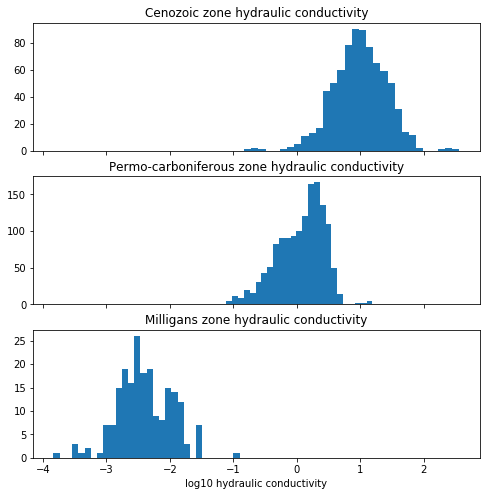

In [55]:
# Plot the histograms for all the aquifers

fig, ax_array = plt.subplots(3,1, figsize = (8,8), sharex = True)


ax_array[0].hist(np.log10(df_SNMR_inversions_nonzero[ceno_mask]['K'].values),
                 bins = 30)
ax_array[0].set_title('Cenozoic zone hydraulic conductivity')

ax_array[1].hist(np.log10(df_SNMR_inversions_nonzero[pcarb_mask]['K'].values),
                 bins = 30)
ax_array[1].set_title('Permo-carboniferous zone hydraulic conductivity')

ax_array[2].hist(np.log10(df_SNMR_inversions_nonzero[mill_mask]['K'].values),
                 bins = 30)
ax_array[2].set_title('Milligans zone hydraulic conductivity')

ax_array[2].set_xlabel('log10 hydraulic conductivity')

plt.savefig(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\aquifer_histogram.png")
plt.show()

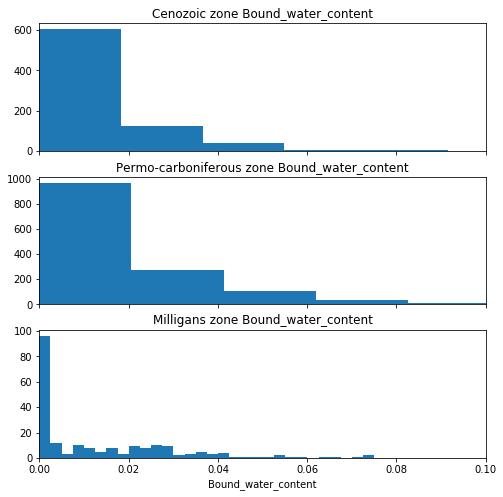

In [61]:
# Plot the histograms for all the aquifers

variable = 'Bound_water_content'

fig, ax_array = plt.subplots(3,1, figsize = (8,8), sharex = True)


ax_array[0].hist(df_SNMR_inversions[ceno_mask][variable].values,
                 bins = 30)
ax_array[0].set_title('Cenozoic zone '  + variable)

ax_array[1].hist(df_SNMR_inversions[pcarb_mask][variable].values,
                 bins = 30)
ax_array[1].set_title('Permo-carboniferous zone ' + variable)

ax_array[2].hist(df_SNMR_inversions[mill_mask][variable].values,
                 bins = 30)
ax_array[2].set_title('Milligans zone ' + variable)

ax_array[2].set_xlabel(variable)

ax_array[2].set_xlim([0,0.1])

plt.savefig(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\\" \
            + variable + "_histogram.png")
plt.show()

In [62]:
# Export

outdir= r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\data"

outfile = os.path.join(outdir, "EK_SNMR_labelled.csv")

df_SNMR_inversions.to_csv(outfile)

In [63]:
# Now we average all the K values in log space for each hydrostratigraphic unit
# for each bore

# Get the log K
df_SNMR_inversions_nonzero['log_K'] = np.log10(df_SNMR_inversions_nonzero['K'])

# Remove 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


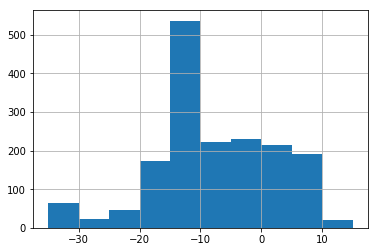

In [64]:
df_SNMR_inversions_nonzero['base_ceno'].hist()

In [66]:
#
for unit in df_SNMR_inversions.label.unique():
    # Export each individual units to a csv
    mask = df_SNMR_inversions.label == unit
    
                          
    df_strat = df_SNMR_inversions[mask]
    
    # Export to csv
    outfile = os.path.join(outdir, unit + "_SNMR_inversion_results.csv")
    df_strat.to_csv(outfile)
    
    # Now we also want to average the log10 conductivity for each unit at each site
    mask = df_strat['K'] != 0
    
    # Get log10 K
    df_strat = df_strat[mask]
    
    if len(df_strat) > 0:
    
        df_strat['log_K'] = np.log10(df_strat['K'])
    
        # Now group by acquisition id and find the median
    
        df_strat_ave = df_strat.groupby(['acquisition_id']).median()
    
        # Export to csv
        outfile = os.path.join(outdir, unit + "_median_observation.csv")
        df_strat_ave.to_csv(outfile)
    

In [ ]:
df_strat